# Phytoplankton Population Processing for Frontend Visualization

This notebook processes PACE OCI MOANA (Phytoplankton) data and exports it as JSON for the React frontend.

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import json
from datetime import datetime

# Get the dataset directory
dataset_dir = f"{os.path.dirname(os.getcwd())}/datasets"
phyto_dir = f"{dataset_dir}/realtime_phytoplankton_populations"

print(f"Phytoplankton data directory: {phyto_dir}")

Phytoplankton data directory: /home/luke/Code/wolfram-nasa-hackathon-2025/datasets/realtime_phytoplankton_populations


In [2]:
# List available phytoplankton files
phyto_files = sorted(glob.glob(f"{phyto_dir}/PACE_OCI.*.L4m.*.MOANA.*.nc"))
print(f"Found {len(phyto_files)} phytoplankton data files\n")

# Show the most recent files
print("Most recent files:")
for file in phyto_files[-5:]:
    print(f"  {os.path.basename(file)}")

Found 24 phytoplankton data files

Most recent files:
  PACE_OCI.20251001.L4m.DAY.MOANA.V3_1.4km.NRT.nc
  PACE_OCI.20251002.L4m.DAY.MOANA.V3_1.0p1deg.NRT.nc
  PACE_OCI.20251002.L4m.DAY.MOANA.V3_1.4km.NRT.nc
  PACE_OCI.20251003.L4m.DAY.MOANA.V3_1.0p1deg.NRT.nc
  PACE_OCI.20251003.L4m.DAY.MOANA.V3_1.4km.NRT.nc


In [3]:
# Load the most recent file with 0.1 degree resolution for balance between detail and performance
# The 0p1deg files are smaller and easier to process while still providing good coverage
degree_files = [f for f in phyto_files if '.0p1deg.' in f]

if degree_files:
    # Use the most recent 0.1 degree file
    latest_file = degree_files[-1]
else:
    # Fallback to the most recent file
    latest_file = phyto_files[-1]

print(f"Loading: {os.path.basename(latest_file)}")

# Open the dataset
ds = xr.open_dataset(latest_file)
print(f"\nDataset info:")
print(f"  Variables: {list(ds.data_vars)}")
print(f"  Dimensions: {ds.dims}")
print(f"  Coordinates: {list(ds.coords)}")

# Show available phytoplankton variables
print(f"\nPhytoplankton variables:")
for var in ds.data_vars:
    if hasattr(ds[var], 'long_name'):
        print(f"  {var}: {ds[var].long_name}")
    else:
        print(f"  {var}: (no description)")

Loading: PACE_OCI.20251003.L4m.DAY.MOANA.V3_1.0p1deg.NRT.nc

Dataset info:
  Variables: ['prococcus_moana', 'syncoccus_moana', 'picoeuk_moana', 'palette']
  Dimensions: FrozenMappingWarningOnValuesAccess({'lat': 1400, 'lon': 1100, 'rgb': 3, 'eightbitcolor': 256})
  Coordinates: ['lat', 'lon']

Phytoplankton variables:
  prococcus_moana: cell abundances of Prochlorococcus
  syncoccus_moana: cell abundances of Synechococcus
  picoeuk_moana: cell abundances of picoeukaryotes
  palette: (no description)


In [4]:
# Extract phytoplankton data
# MOANA datasets typically contain different phytoplankton groups
# We'll look for chlorophyll or total phytoplankton concentration

# Common variable names for phytoplankton data
possible_vars = ['chlor_a', 'chl', 'phytoplankton', 'chl_occci', 'carbon_phyto', 
                 'diatoms', 'dinoflagellates', 'green_algae', 'cyanobacteria',
                 'prochlorococcus', 'synechococcus', 'haptophytes']

# Find which variables are present
available_vars = [var for var in possible_vars if var in ds.data_vars]

# If no specific phytoplankton vars found, list all available data variables
if not available_vars:
    available_vars = list(ds.data_vars)
    # Filter out metadata variables
    available_vars = [v for v in available_vars if v not in ['palette', 'qual', 'quality', 'l2_flags']]

print(f"Available phytoplankton data variables: {available_vars}")

# Use the first available variable (usually the primary measurement)
if available_vars:
    primary_var = available_vars[0]
    print(f"\nUsing primary variable: {primary_var}")
    phyto_data = ds[primary_var]
    
    # Get coordinates
    lons = ds['lon'].values if 'lon' in ds.coords else ds['longitude'].values
    lats = ds['lat'].values if 'lat' in ds.coords else ds['latitude'].values
    
    print(f"Data shape: {phyto_data.shape}")
    print(f"Longitude range: [{lons.min():.2f}, {lons.max():.2f}]")
    print(f"Latitude range: [{lats.min():.2f}, {lats.max():.2f}]")
else:
    print("No suitable phytoplankton variables found")

Available phytoplankton data variables: ['prococcus_moana', 'syncoccus_moana', 'picoeuk_moana']

Using primary variable: prococcus_moana
Data shape: (1400, 1100)
Longitude range: [-84.95, 24.95]
Latitude range: [-69.95, 69.95]


In [5]:
# Get statistics for the phytoplankton data
if available_vars:
    phyto_values = phyto_data.values
    valid_phyto = phyto_values[~np.isnan(phyto_values)]
    
    if len(valid_phyto) > 0:
        print(f"\nPhytoplankton concentration statistics:")
        print(f"  Min: {valid_phyto.min():.6f}")
        print(f"  Max: {valid_phyto.max():.6f}")
        print(f"  Mean: {valid_phyto.mean():.6f}")
        print(f"  Median: {np.median(valid_phyto):.6f}")
        print(f"  Valid points: {len(valid_phyto):,} / {phyto_values.size:,}")
        
        # Check units if available
        if hasattr(phyto_data, 'units'):
            print(f"  Units: {phyto_data.units}")


Phytoplankton concentration statistics:
  Min: -2147483648.000000
  Max: 923369.000000
  Mean: -33373509.737936
  Median: 194350.000000
  Valid points: 215,894 / 1,540,000
  Units: cells ml^-1


In [6]:
# Process phytoplankton data for heatmap visualization
# Export actual concentration values - NO normalization

# Prepare heatmap data in [lat, lng, concentration] format
heat_data = []

# Determine sampling factor based on file resolution
if '.0p1deg.' in latest_file:
    # 0.1 degree resolution - moderate sampling
    sample_factor = 2  # Sample every 2nd point for 0.2 degree resolution
elif '.4km.' in latest_file:
    # 4km resolution - more aggressive sampling
    sample_factor = 20  # Sample every 20th point
else:
    # Default sampling
    sample_factor = 5

print(f"Processing phytoplankton data with sampling factor: {sample_factor}")
print(f"This will create a grid with approximately {len(lons)//sample_factor} x {len(lats)//sample_factor} points")

for i in range(0, len(lons), sample_factor):
    for j in range(0, len(lats), sample_factor):
        concentration = phyto_values[j, i]  # Note: NetCDF typically stores as (lat, lon)
        
        if not np.isnan(concentration) and concentration > 0:  # Filter out zero/negative values
            # Convert lon from 0-360 to -180-180 if needed
            lon = float(lons[i])
            if lon > 180:
                lon = lon - 360
            
            # Store actual concentration value
            heat_data.append([float(lats[j]), lon, float(concentration)])

print(f"\nGenerated {len(heat_data):,} phytoplankton data points")

# Calculate actual resolution in degrees
if '.0p1deg.' in latest_file:
    grid_resolution = sample_factor * 0.1
elif '.4km.' in latest_file:
    grid_resolution = sample_factor * 0.04
else:
    grid_resolution = sample_factor * 0.1
    
print(f"Grid resolution: approximately {grid_resolution:.2f} degrees (~{grid_resolution * 111:.0f} km at equator)")

# Show concentration range in the exported data
if heat_data:
    concentrations_in_data = [point[2] for point in heat_data]
    print(f"\nConcentration range in exported data:")
    print(f"  Min: {min(concentrations_in_data):.6f}")
    print(f"  Max: {max(concentrations_in_data):.6f}")
    print(f"  Mean: {np.mean(concentrations_in_data):.6f}")
    
    # Check regional variations
    equator_conc = [p[2] for p in heat_data if -10 < p[0] < 10]
    north_conc = [p[2] for p in heat_data if p[0] > 30]
    south_conc = [p[2] for p in heat_data if p[0] < -30]
    
    if equator_conc:
        print(f"\nEquatorial region: {min(equator_conc):.6f} to {max(equator_conc):.6f}")
    if north_conc:
        print(f"Northern region (>30°N): {min(north_conc):.6f} to {max(north_conc):.6f}")
    if south_conc:
        print(f"Southern region (<30°S): {min(south_conc):.6f} to {max(south_conc):.6f}")

Processing phytoplankton data with sampling factor: 2
This will create a grid with approximately 550 x 700 points

Generated 44,336 phytoplankton data points
Grid resolution: approximately 0.20 degrees (~22 km at equator)

Concentration range in exported data:
  Min: 2.000000
  Max: 826016.000000
  Mean: 227931.801358

Equatorial region: 57.000000 to 669513.000000
Northern region (>30°N): 2.000000 to 590006.000000
Southern region (<30°S): 38.000000 to 826016.000000


In [7]:
# Save phytoplankton data to JSON for frontend
output_path = '../frontend/src/pages/landing/phytoplankton_data.json'

# Create metadata to help frontend understand the data
metadata = {
    "variable": primary_var if available_vars else "unknown",
    "units": phyto_data.units if hasattr(phyto_data, 'units') else "concentration",
    "date": os.path.basename(latest_file).split('.')[1],  # Extract date from filename
    "min_value": float(min(concentrations_in_data)) if heat_data else 0,
    "max_value": float(max(concentrations_in_data)) if heat_data else 1,
    "mean_value": float(np.mean(concentrations_in_data)) if heat_data else 0.5
}

# Combine data and metadata
output_data = {
    "metadata": metadata,
    "data": heat_data
}

with open(output_path, 'w') as f:
    json.dump(output_data, f)

print(f"\nSaved phytoplankton data to {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")
print(f"\nMetadata saved:")
for key, value in metadata.items():
    print(f"  {key}: {value}")


Saved phytoplankton data to ../frontend/src/pages/landing/phytoplankton_data.json
File size: 2.06 MB

Metadata saved:
  variable: prococcus_moana
  units: cells ml^-1
  date: 20251003
  min_value: 2.0
  max_value: 826016.0
  mean_value: 227931.80135781306


/tmp/ipykernel_242359/1275628455.py:16: RuntimeWarning: invalid value encountered in log10
  ax1.axvline(np.log10(valid_phyto.mean()),


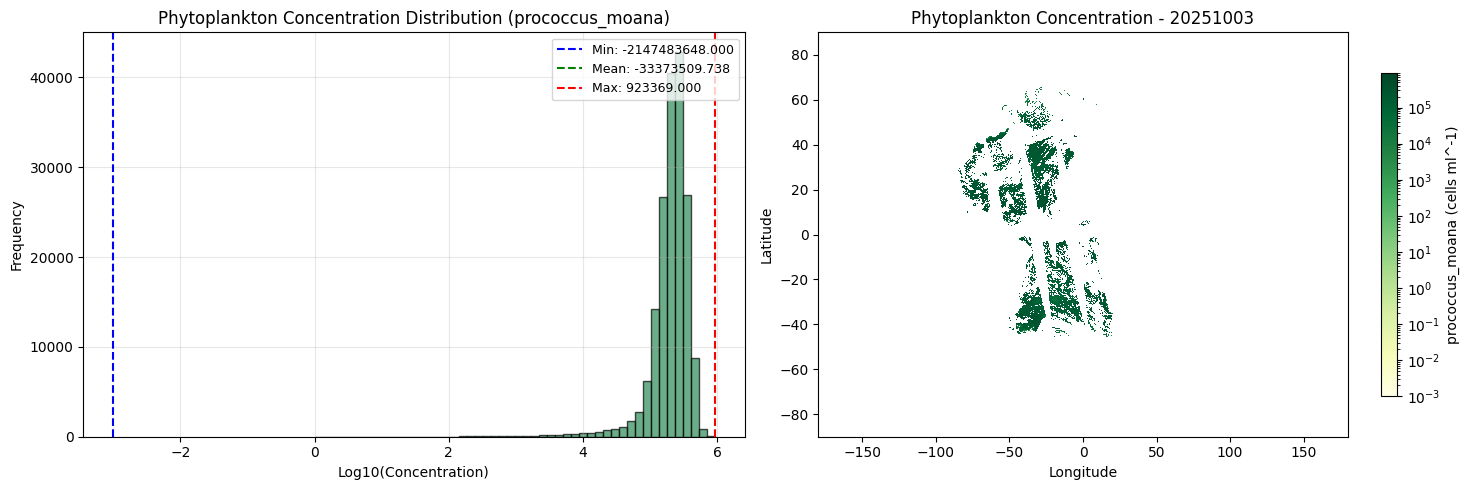


Visualization complete.


In [8]:
# Optional: Create a visualization to verify the data
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

if available_vars and len(valid_phyto) > 0:
    # Create a simple plot to verify the phytoplankton distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Concentration distribution histogram (log scale)
    # Use log scale for better visualization of phytoplankton concentrations
    log_valid = np.log10(valid_phyto[valid_phyto > 0])  # Log transform positive values
    
    ax1.hist(log_valid, bins=50, edgecolor='black', alpha=0.7, color='seagreen')
    ax1.axvline(np.log10(valid_phyto.min()) if valid_phyto.min() > 0 else -3, 
                color='blue', linestyle='--', label=f'Min: {valid_phyto.min():.3f}')
    ax1.axvline(np.log10(valid_phyto.mean()), 
                color='green', linestyle='--', label=f'Mean: {valid_phyto.mean():.3f}')
    ax1.axvline(np.log10(valid_phyto.max()), 
                color='red', linestyle='--', label=f'Max: {valid_phyto.max():.3f}')
    
    ax1.set_xlabel('Log10(Concentration)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Phytoplankton Concentration Distribution ({primary_var})')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Global phytoplankton map
    # Use a green colormap for phytoplankton (chlorophyll-like)
    cmap = plt.cm.YlGn  # Yellow-Green colormap
    # Use log normalization for better visualization
    norm = mcolors.LogNorm(vmin=max(valid_phyto.min(), 0.001), vmax=valid_phyto.max())
    
    # Create meshgrid for plotting
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Plot the phytoplankton data
    im = ax2.pcolormesh(lon_grid, lat_grid, phyto_values, cmap=cmap, norm=norm, shading='auto')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title(f'Phytoplankton Concentration - {os.path.basename(latest_file).split(".")[1]}')
    ax2.set_xlim(-180, 180)
    ax2.set_ylim(-90, 90)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2, label=f'{primary_var} ({phyto_data.units if hasattr(phyto_data, "units") else "concentration"})', shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization complete.")
else:
    print("No data available for visualization")